# Power grid example case 9


$\Gamma = 0$,

__case-9__

Perburbations = large

Splitting time-series according to perturbation points

$\Gamma = 0$,

Perburbations = large

Splitting time-series according to perturbation points

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import coo_array

from os import path

## Loading data

In [2]:
folder_name = "case"
folder_location = path.join("powergrid","Datasets", folder_name)

#### Reading time series data and skipping rows to sub sample

In [3]:
# #Trimming original time series to reduce the number of data points
# data_matrix_df_orig = pd.read_csv(path.join(folder_location, "{}_timeseries.csv".format(folder_name)))
# skip_n_rows_btw = 100
# rows_to_keep = np.arange(0, len(data_matrix_df_orig), skip_n_rows_btw)

# data_matrix_df = data_matrix_df_orig.iloc[rows_to_keep].reset_index(drop=True)

# data_matrix_df.to_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)), index=False)

In [4]:
data_matrix_df = pd.read_csv(path.join(folder_location, "{}_trimmed_time_series.csv".format(folder_name)))

FileNotFoundError: [Errno 2] No such file or directory: 'powergrid/Datasets/case/case_trimmed_time_series.csv'

In [ ]:
data_matrix_df

In [5]:
def column_label_changer(column_label):
    if "PhaseGenTerm" in column_label:
        new_label = "Phi_T_{}".format(column_label[-1])
    elif "PhaseGen" in column_label:
        new_label = "Phi_G_{}".format(column_label[-1])
    elif "PhaseLoad" in column_label:
        new_label = "Phi_L_{}".format(column_label[-1])
    elif "FreqGenTerm" in column_label:
        new_label = "om_T_{}".format(column_label[-1])
    elif "FreqGen" in column_label:
        new_label = "om_G_{}".format(column_label[-1])
    elif "FreqLoad" in column_label:
        new_label = "om_L_{}".format(column_label[-1])
    elif "ActivePowerGenTerm" in column_label:
        new_label = "P_T_{}".format(column_label[-1])
    elif "ActivePowerGen" in column_label:
        new_label = "P_G_{}".format(column_label[-1])
    elif "ActivePowerLoad" in column_label:
        new_label = "P_L_{}".format(column_label[-1])
    elif "ReactivePowerGenTerm" in column_label:
        new_label = "Q_T_{}".format(column_label[-1])
    elif "ReactivePowerGen" in column_label:
        new_label = "Q_G_{}".format(column_label[-1])
    elif "ReactivePowerLoad" in column_label:
        new_label = "Q_L_{}".format(column_label[-1])
    else:
        new_label = column_label
    return new_label

In [8]:
column_label_dict = {column: column_label_changer(column) for column in data_matrix_df.columns}
column_label_dict

{'time': 'time',
 'PhaseGen1': 'Phi_G_1',
 'PhaseGen2': 'Phi_G_2',
 'PhaseGen3': 'Phi_G_3',
 'PhaseGenTerm1': 'Phi_T_1',
 'PhaseGenTerm2': 'Phi_T_2',
 'PhaseGenTerm3': 'Phi_T_3',
 'PhaseLoad1': 'Phi_L_1',
 'PhaseLoad2': 'Phi_L_2',
 'PhaseLoad3': 'Phi_L_3',
 'PhaseLoad4': 'Phi_L_4',
 'PhaseLoad5': 'Phi_L_5',
 'PhaseLoad6': 'Phi_L_6',
 'FreqGen1': 'om_G_1',
 'FreqGen2': 'om_G_2',
 'FreqGen3': 'om_G_3',
 'FreqGenTerm1': 'om_T_1',
 'FreqGenTerm2': 'om_T_2',
 'FreqGenTerm3': 'om_T_3',
 'FreqLoad1': 'om_L_1',
 'FreqLoad2': 'om_L_2',
 'FreqLoad3': 'om_L_3',
 'FreqLoad4': 'om_L_4',
 'FreqLoad5': 'om_L_5',
 'FreqLoad6': 'om_L_6',
 'ActivePowerGen1': 'P_G_1',
 'ActivePowerGen2': 'P_G_2',
 'ActivePowerGen3': 'P_G_3',
 'ActivePowerGenTerm1': 'P_T_1',
 'ActivePowerGenTerm2': 'P_T_2',
 'ActivePowerGenTerm3': 'P_T_3',
 'ActivePowerLoad1': 'P_L_1',
 'ActivePowerLoad2': 'P_L_2',
 'ActivePowerLoad3': 'P_L_3',
 'ActivePowerLoad4': 'P_L_4',
 'ActivePowerLoad5': 'P_L_5',
 'ActivePowerLoad6': 'P_L_6',
 'Rea

In [9]:
# new_column_names = ["time", "Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
#                    "om_0", "om_1", "om_2", "om_3","om_4", "om_5", "P_0", "P_1", "P_2", "P_3", "P_4", "P_5",
#                    "Q_0", "Q_1", "Q_2", "Q_3", "Q_4", "Q_5"]

#Renaming the state variables for compactness
data_matrix_df.rename(columns= column_label_dict, inplace=True)

In [10]:
power_features = [feature for feature in data_matrix_df.columns if "P_" in feature]
freq_features = [feature for feature in data_matrix_df.columns if "om_" in feature]
phase_features = [feature for feature in data_matrix_df.columns if "Phi_" in feature]

K_features = [feature[2:] for feature in power_features]

In [11]:
#Removing Reactive power from the timeseries they are not needed for fitting 
non_reactive_columns = [column for column in data_matrix_df.columns if "Q" not in column]

data_matrix_df = data_matrix_df[non_reactive_columns]

In [12]:
data_matrix_df

,time,Phi_G_1,Phi_G_2,Phi_G_3,Phi_T_1,Phi_T_2,Phi_T_3,Phi_L_1,Phi_L_2,Phi_L_3,...,P_G_3,P_T_1,P_T_2,P_T_3,P_L_1,P_L_2,P_L_3,P_L_4,P_L_5,P_L_6
0,0.00000000,0.00000000,0.17493161,0.08962591,0.00000000,0.17493161,0.08962591,0.00000000,0.00000000,0.00000000,...,-0.00000000,-0.00000000,2.76314523,1.52994732,-0.00000000,-0.00000000,-1.52994732,-0.00000000,-2.76314523,-0.00000000
1,0.01000000,0.00226994,0.17677555,0.09170017,-0.00754757,0.09919137,0.04321799,-0.02019207,-0.03925939,0.01724354,...,0.16830950,0.19305122,0.36446761,0.27562804,0.31250747,-0.53396275,0.16895517,-0.93976188,0.17747953,-0.83922543
2,0.02000000,0.00863305,0.18138775,0.09727114,-0.02401611,0.08308766,0.02740875,-0.04245157,-0.06348650,0.00260212,...,0.24243021,0.23473523,0.17976611,0.18155204,0.27751241,-0.61090695,0.19886327,-0.82541167,0.19313714,-0.94948466
3,0.03000000,0.01831563,0.18810176,0.10565762,-0.04058124,0.07448946,0.01544889,-0.06204371,-0.08368684,-0.01183774,...,0.31286428,0.22010162,0.13270099,0.15349487,0.24228288,-0.65098373,0.18227255,-0.82087220,0.16257359,-1.00235042
4,0.04000000,0.03054028,0.19646660,0.11627178,-0.05509153,0.06883114,0.00543636,-0.07901397,-0.10120527,-0.02472581,...,0.38413657,0.19455355,0.10701043,0.13135462,0.20811093,-0.68382242,0.15900720,-0.84183515,0.13357609,-1.04068399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,59.95710000,0.29325016,0.41653286,0.37830296,0.04793282,0.22283576,0.13762958,0.00908341,-0.01757547,0.08785886,...,0.82779710,0.05083751,0.07092273,0.02259468,-0.00003723,-0.90005637,-0.00005946,-0.99986096,0.00028538,-1.24993021
5997,59.96710000,0.29327502,0.41647430,0.37834082,0.04793890,0.22280045,0.13764053,0.00908580,-0.01757174,0.08786264,...,0.82788788,0.05085471,0.07088291,0.02262641,-0.00002624,-0.90004243,-0.00004082,-0.99985879,0.00027384,-1.24992605
5998,59.97710000,0.29329763,0.41642157,0.37837256,0.04794397,0.22276764,0.13764929,0.00908738,-0.01756906,0.08786503,...,0.82796539,0.05087163,0.07084095,0.02265749,-0.00001566,-0.90002888,-0.00002287,-0.99985843,0.00025979,-1.24992304
5999,59.98710000,0.29331786,0.41637491,0.37839818,0.04794804,0.22273756,0.13765588,0.00908818,-0.01756738,0.08786611,...,0.82802955,0.05088810,0.07079749,0.02268759,-0.00000561,-0.90001587,-0.00000578,-0.99985976,0.00024358,-1.24992116


In [16]:
final_time = 20

In [17]:
data_matrix_df = data_matrix_df[data_matrix_df["time"] <= final_time]

<Axes: >

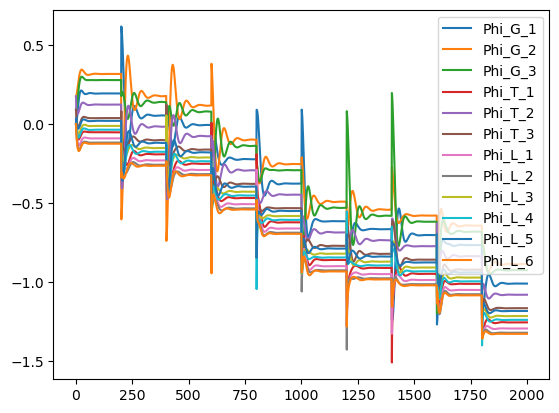

In [15]:
data_matrix_df[phase_features].plot()

In [18]:
from copy import deepcopy

In [19]:
df_case_9 = deepcopy(data_matrix_df)

In [22]:
data_matrix_df[power_features].sum(axis=1).plot()

### Reading gamma values 

In [23]:
gamma_df = pd.read_csv(path.join(folder_location, "{}_gamma.csv".format(folder_name)), names=K_features)

In [24]:
gamma_df

### Splitting the time-series with respect to the perturbation points

In [25]:
#Getting perturbations time points
perturbation_points_df = pd.read_csv(path.join(folder_location, "{}_timepoints.csv".format(folder_name)))

perturbation_points_df = perturbation_points_df[perturbation_points_df["Perturbation timepoints"] <= final_time]

In [26]:
perturbation_time_point_list = perturbation_points_df["Perturbation timepoints"]
# perturbation_time_point_list

In [27]:
perturbation_time_point_list

In [28]:
#Splitting the data_matrix with the timeseries into a list of timeseries dataframes based on where the perturbation is introduced
#The purpose of this step is to smoothen each of perturbation segment independently using splines and find the derivaties
#This will avoid jumps in the derivative due to the discontinuity at the perturbanc time point

data_matrix_df_list =[data_matrix_df[(ind_i < data_matrix_df["time"]) & (data_matrix_df["time"] < ind_j) ] 
                       for ind_i, ind_j in zip(perturbation_time_point_list[:-1], perturbation_time_point_list[1:])]


data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)

data_matrix_df_appended

#### Loading admittance matrix, Y

In [29]:
admittance_Y_df = pd.read_csv(path.join(folder_location, "{}_Y.csv".format(folder_name)), names=K_features)
admittance_Y_df.set_index(pd.Index(K_features), inplace=True)
for column in admittance_Y_df.columns:
    admittance_Y_df[column] = admittance_Y_df[column].apply(lambda x: x.replace('i', 'j'))

In [30]:
admittance_Y_df

#### Loading static parameters

In [31]:
static_param_df = pd.read_csv(path.join(folder_location, "{}_staticparams.csv".format(folder_name)))

In [32]:
static_param_df

#### Loading coupling matrix, K

In [33]:
coupling_K_df = pd.read_csv(path.join(folder_location, "{}_K.csv".format(folder_name)), names=K_features)
coupling_K_df.set_index(pd.Index(K_features), inplace=True)

In [34]:
coupling_K_df

In [35]:
coupling_matrix_true = coupling_K_df .to_numpy()
coupling_matrix_true

## Forming candidate library for powersystems

In [36]:
gamma_df

In [37]:
gamma_matrix = gamma_df.to_numpy()
admittance_Y_matrix = admittance_Y_df.to_numpy()

gamma_matrix

In [38]:
coupling_matrix_init = np.ones(admittance_Y_matrix.shape)
# coupling_matrix_init = np.zeros(admittance_Y_matrix.shape)
# coupling_matrix_init[3,:] = 1

coupling_matrix_init = np.triu(coupling_matrix_init, 0)
coupling_matrix_init
sparse_coupling_matrix_init = coo_array(coupling_matrix_init)
sparse_coupling_matrix_init.toarray()

### Defining the sin interaction terms 

In [39]:
from dae_finder import FeatureCouplingTransformer

def coup_fun_sin_diff(x,y,i,j,gam_matrix):
    return np.sin(x-y- gam_matrix[i,j])

def coup_namer_sin_diff(x,y,i,j,gam_matrix=None):
    return "sin( {}-{} -gamma_{},{} )".format(x,y,i,j)


# def coup_fun_diff(x,y,i,j,gam_matrix):
#     return x-y- gam_matrix[i,j]

# def coup_namer_diff(x,y,i,j,gam_matrix):
#     return "{}-{} -gamma_{},{}".format(x,y,i,j)

transfomrer_sin_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
                                           coupling_func= coup_fun_sin_diff,
                                           coupling_namer= coup_namer_sin_diff,
                                           coupling_func_args={"gam_matrix":gamma_matrix},
                                              return_df=True)

# transformer_diff = FeatureCouplingTransformer(sparse_coupling_matrix_init,
#                                            coupling_func= coup_fun_diff,
#                                            coupling_namer= coup_namer_diff,
#                                            coupling_func_args={"gam_matrix":gamma_matrix},
#                                               return_df=True)

In [40]:
#Creating library with sin(load angle difference)
sin_diff_library = transfomrer_sin_diff.fit_transform(data_matrix_df_appended.drop(["time"], axis=1))
# sin_diff_library = transfomrer_sin_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))

cop_ind = transfomrer_sin_diff.coupled_indices_list

# #Creating library with load angle difference
# diff_library = transformer_diff.fit_transform(data_matrix_df.drop(["time"], axis=1))


In [41]:
sin_diff_library

In [47]:
# candidate_lib = pd.concat([data_matrix_df.drop("time", axis=1), sin_diff_library], axis=1)

candidate_lib = pd.concat([data_matrix_df_appended.drop("time", axis=1), sin_diff_library], axis=1)

In [48]:
candidate_lib

### Removing zero features

In [49]:
non_zero_column_series = (candidate_lib**2).sum() > 0.00001
non_zero_column_series
non_columns = [column for column in candidate_lib if non_zero_column_series[column]]

candidate_lib = candidate_lib[non_columns]

## Smoothening data and finding derivatives using splines

In [50]:
from dae_finder import add_noise_to_df

noise_perc = 0
# data_matrix_df_list = [data_matrix_df]
num_time_points = len(data_matrix_df_list[0])
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["time"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["time"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

In [51]:
from dae_finder import smooth_data

# Calling the smoothening function
data_matrix_smooth_df_list = [smooth_data(data_matrix, domain_var="time", derr_order=1, noise_perc=noise_perc) for
                              data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) > 1:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
# if "time" in data_matrix_df_smooth:
#     data_matrix_df_smooth = data_matrix_df_smooth.drop("time", axis=1)

In [52]:
(data_matrix_df_smooth - data_matrix_df_appended).sum()

In [62]:
ind = 3
feature_ = "Phi_L_4"

plt.figure()
# plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
#         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

plt.plot(data_matrix_df_list[ind]["time"], data_matrix_df_list[ind][feature_], ".",
         data_matrix_smooth_df_list[ind]["time"],
         data_matrix_smooth_df_list[ind][feature_], ".",
         data_matrix_df_list[ind][ind * num_time_points:(ind + 1) * num_time_points]["time"],
         data_matrix_df_list[ind][ind * num_time_points:(ind + 1) * num_time_points][feature_], ".")
plt.legend(['Noisy', 'Cubic Spline', 'True'])
# plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
plt.show()

## Finding Algebraic relationship

### Using sympy to find factors of redundant feature and refine the library

In [63]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df_appended.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_appended.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [64]:
data_matrix_df_smooth_appended.columns

In [65]:
data_matrix_features

In [66]:
feature_list = list(data_matrix_features)
feature_list.remove('time')

feature_list

In [67]:
refined_candid_lib = data_matrix_df_smooth_appended[feature_list]

In [68]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib), columns=s_scaler.feature_names_in_)

In [69]:
candidate_lib

# Using Lasso

## Finding the conservation laws

In [243]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       alpha=0.3,
                                       fit_intercept=True)

In [252]:
# features_to_fit_ = ["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
#                     "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# features_to_fit_ = ["P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# num_nodes = 6
# power_features = ["P_{}".format(ind) for ind in range(num_nodes)]

# Mapping each power feature to possible expressions in the algebraic relationship. This is done by taking the power features and frequency
# feature from the candidate library
feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}

algebraic_model_lasso.fit(candidate_lib, scale_columns=True,
                          features_to_fit=power_features,
                          feature_to_library_map=feature_to_libr_map)


In [253]:
# special_scaled_lib = scaled_cand_lib.drop(power_features, axis=1)
# special_scaled_lib = pd.concat((special_scaled_lib, candidate_lib[power_features]), axis=1)

In [254]:
# # features_to_fit_ = ["Phi_0", "Phi_1", "Phi_2", "Phi_3", "Phi_4", "Phi_5",
# #                     "P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# # features_to_fit_ = ["P_0", "P_1", "P_2", "P_3", "P_4", "P_5"]
# # num_nodes = 6
# # power_features = ["P_{}".format(ind) for ind in range(num_nodes)]

# # Mapping each power feature to possible expressions in the algebraic relationship. This is done by taking the power features and frequency
# # feature from the candidate library

# seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


# algebraic_model_lasso = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

# # dynamic_model_th.fit(X=refined_candid_lib_appended,
# #                      scale_columns=False,
# #                      features_to_fit=dynamic_feat_to_fit,
# #                      feature_to_library_map=dynamic_feature_to_libr_map)
# feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}

# algebraic_model_lasso.fit(X=candidate_lib,
#                                   scale_columns=True,
#                                   features_to_fit=power_features,
#                                   feature_to_library_map=feature_to_libr_map)


In [246]:
algebraic_model_lasso.best_models()

In [247]:
for feat in power_features:
    print(feat)
    print(algebraic_model_lasso.best_models()[feat][abs(algebraic_model_lasso.best_models()[feat])>0.1])

### Checking model accuracy

### Extracting true models from the true coupling matrix

In [248]:
fitted_models = algebraic_model_lasso.best_models()[:-1]

In [249]:
true_models = pd.DataFrame(columns=fitted_models.columns, index=fitted_models.index)
true_models.fillna(0, inplace=True)
for ind_i, power_feat in enumerate(power_features):
    for ind_j in range(len(power_features)):
        if abs(coupling_matrix_true[ind_i, ind_j]) > 0.1:
            # true_models.loc[feat_name, power_feat] = coupling_matrix_true[ind_i, ind_j]
            low_ind = min(ind_i, ind_j)
            up_ind = max(ind_i, ind_j)
            feat_name = coup_namer_sin_diff(phase_features[low_ind], phase_features[up_ind],
                                        low_ind, up_ind)
            # print(feat_name)
            true_models.loc[feat_name, power_feat] = 20.0
            
            # print(ind_i, ind_j, coupling_matrix_true[ind_i, ind_j])
        # true_models[power_feat][feat_name] = "haha"
        # print(ind_i, ind_j, feat_name)
        # print(true_models[power_feat])

In [250]:
# def compare_models(models_df_1, models_df_2, tol=1.e-5):
#     assert models_df_1.shape == models_df_2.shape, "both model dataframes should be of the same shape"
#     assert all(models_df_1.columns == models_df_2.columns) and all(models_df_1.index == models_df_2.index)

#     models_df_1[abs(models_df_1) > tol] = 1
#     models_df_1[abs(models_df_1) <= tol] = 0

#     models_df_2[abs(models_df_2) > tol] = 1
#     models_df_2[abs(models_df_2) <= tol] = 0

#     model_diff_df = models_df_1 - models_df_2

#     model_diff_df.loc["# incosistent terms"] = abs(model_diff_df).sum()

#     return model_diff_df

In [251]:
from dae_finder import compare_models_

compare_models_(true_models, fitted_models)

## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [64]:
from sklearn.linear_model import Lasso

alg_lasso = Lasso(fit_intercept=True, alpha=0.3)
alg_lasso.fit(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_refined_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [66]:
coef_dict = dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))
coef_dict

In [67]:
seq_th_model.intercept_

In [68]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

In [69]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [70]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

### Full candidate library is unable to find the model 

In [42]:
alg_lasso.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
alg_lasso.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [43]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

# Using Sequential Thresholding

## Finding the conservation laws

In [78]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression
lin_reg_model_arg = {"fit_intercept": True}
seq_th_model = sequentialThLin(custom_model=True,
                               custom_model_ob = lin_reg_model,
                               custom_model_arg= lin_reg_model_arg,
                              coef_threshold=0.1)
# seq_th_model = sequentialThLin(coef_threshold=0.1, alpha=0.1, fit_intercept=True)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

In [79]:
feature_to_libr_map = {power_feat: candidate_lib.columns.drop(power_features+freq_features) for power_feat in power_features}

algebraic_model_th.fit(candidate_lib, scale_columns=False,
                       features_to_fit=power_features,
                       feature_to_library_map=feature_to_libr_map)


In [80]:
freq_features

In [81]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

In [82]:
algebraic_model_th.get_fitted_intercepts()

In [83]:
for feat in power_features:
    print(feat)
    print(algebraic_model_th.best_models()[feat][abs(algebraic_model_th.best_models()[feat])>0.1])

### Checking model accuracy

### Extracting true models from the true coupling matrix

In [84]:
fitted_models = algebraic_model_th.best_models()[:-1]

In [85]:
true_models = pd.DataFrame(columns=fitted_models.columns, index=fitted_models.index)
true_models.fillna(0, inplace=True)
for ind_i, power_feat in enumerate(power_features):
    for ind_j in range(len(power_features)):
        if abs(coupling_matrix_true[ind_i, ind_j]) > 0.1:
            # true_models.loc[feat_name, power_feat] = coupling_matrix_true[ind_i, ind_j]
            low_ind = min(ind_i, ind_j)
            up_ind = max(ind_i, ind_j)
            feat_name = coup_namer_sin_diff(phase_features[low_ind], phase_features[up_ind],
                                        low_ind, up_ind)
            # print(feat_name)
            true_models.loc[feat_name, power_feat] = 20.0
            
            # print(ind_i, ind_j, coupling_matrix_true[ind_i, ind_j])
        # true_models[power_feat][feat_name] = "haha"
        # print(ind_i, ind_j, feat_name)
        # print(true_models[power_feat])

In [86]:
# def compare_models(models_df_1, models_df_2, tol=1.e-5):
#     assert models_df_1.shape == models_df_2.shape, "both model dataframes should be of the same shape"
#     assert all(models_df_1.columns == models_df_2.columns) and all(models_df_1.index == models_df_2.index)

#     models_df_1[abs(models_df_1) > tol] = 1
#     models_df_1[abs(models_df_1) <= tol] = 0

#     models_df_2[abs(models_df_2) > tol] = 1
#     models_df_2[abs(models_df_2) <= tol] = 0

#     model_diff_df = models_df_1 - models_df_2

#     model_diff_df.loc["# incosistent terms"] = abs(model_diff_df).sum()

#     return model_diff_df

In [87]:
from dae_finder import compare_models_

compare_models_(true_models, fitted_models)

## Finding the dynamic equation for generators

### Refined candidate library is able to find the model 

In [88]:
data_matrix_df_smooth_appended[['d(Phi_G_1) /dt', 'om_G_1']].plot()

In [89]:
ind = "L_2"
data_matrix_df_smooth_appended[['d(Phi_{}) /dt'.format(ind), 'om_{}'.format(ind)]].plot()


In [92]:
ind = "L_2"


(abs(data_matrix_df_smooth_appended['d(Phi_{}) /dt'.format(ind)] - data_matrix_df_smooth_appended['om_{}'.format(ind)])).sum()


In [93]:
abs(data_matrix_df_smooth_appended['d(Phi_{}) /dt'.format(ind)]).sum()

In [94]:
scaled_refined_lib[power_features + freq_features]

In [99]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)


ind = "L_2"
seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)
# seq_th_model = sequentialThLin(model_id="RR", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])
seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])

# seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])
# seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])

In [100]:
coef_dict = dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))
coef_dict

### Discovering all frequencies

- Note that frequencies needs to be discovered only for non-generator nodes

In [120]:
thislist = ["apple", "banana", "cherry"]
try:
    thislist.remove("banana")
except ValueError:
    pass

print(thislist)

In [117]:
list.remove?

In [113]:
#Collecting the feature names to fit: This will be d/dt(omega) for generators and omega for non-generator nodes

d_omega_gen_features = [feat for feat in data_matrix_df_smooth_appended.columns if "d(om_G" in feat]
freq_non_gen_features = [feat for feat in freq_features if "G" not in feat]

dynamic_feat_to_fit = d_omega_gen_features + freq_non_gen_features
dynamic_feat_to_fit

In [126]:
combined_features = power_features + phase_features+ freq_features

dynamic_feature_to_libr_map = {feat: [comb_feat for comb_feat in combined_features if feat != comb_feat]
                              for feat in dynamic_feat_to_fit}

In [160]:
scaled_refined_lib[power_features + phase_features+ freq_features]

In [159]:
data_matrix_df_smooth_appended[d_omega_gen_features]

In [169]:
refined_candid_lib_appended = pd.concat((scaled_refined_lib, data_matrix_df_smooth_appended[d_omega_gen_features]), axis=1)

refined_candid_lib_appended

In [172]:
from dae_finder import sequentialThLin, AlgModelFinder
# from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)
# seq_th_model = sequentialThLin(coef_threshold=0.1, alpha=0.1, fit_intercept=True)
seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


dynamic_model_th = AlgModelFinder(custom_model=True, custom_model_ob=seq_th_model)

dynamic_model_th.fit(X=refined_candid_lib_appended,
                     scale_columns=False,
                     features_to_fit=dynamic_feat_to_fit,
                     feature_to_library_map=dynamic_feature_to_libr_map)

In [173]:
dynamic_model_th.best_models()

In [168]:
data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)].describe()

In [151]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)


ind = "G_3"
seq_th_model = sequentialThLin(model_id="lasso", alpha=0.3, coef_threshold=0.1, fit_intercept=True)
# seq_th_model = sequentialThLin(model_id="RR", alpha=0.3, coef_threshold=0.1, fit_intercept=True)


# seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])
# seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['om_{}'.format(ind)])

seq_th_model.fit(X=scaled_refined_lib[power_features + phase_features+ freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])
seq_th_model.score(X=scaled_refined_lib[power_features + phase_features+freq_features], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])

In [152]:
coef_dict = dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))
coef_dict

In [253]:
seq_th_model.intercept_

In [231]:
non_zero_feat = [feat for feat, coef in coef_dict.items() if abs(coef) > 0.01]
non_zero_feat

In [232]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])
lin_model.score(X=scaled_refined_lib[non_zero_feat], y=data_matrix_df_smooth_appended['d(om_{}) /dt'.format(ind)])

In [233]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [234]:
scaled_refined_lib[non_zero_feat]

In [244]:
from sklearn import decomposition
pca_1 = decomposition.PCA()

refined_features = ["Phi_{}".format(ind), "P_{}".format(ind), "om_{}".format(ind)]
pca_1.fit(scaled_refined_lib[refined_features])

var_expl_ratio = pca_1.explained_variance_ratio_
var_expl_ratio

In [245]:
pca_1.components_

In [246]:
scaled_refined_lib[refined_features].corr()

In [243]:
scaled_refined_lib[]

In [224]:
from numpy import linalg

In [225]:
linalg.cond(scaled_refined_lib[non_zero_feat])

In [247]:
linalg.cond(sin_diff_library)

In [248]:
feature_to_libr_map

### Full candidate library is unable to find the model 

In [62]:
seq_th_model.fit(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])
seq_th_model.score(X=scaled_cand_lib, y=data_matrix_df_smooth_appended['d(om_0) /dt'])

In [63]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))